In [1]:
# instalacia kniznice pre pracu s krajinami - iso3, provincie a staty, kontinent
# !pip install --upgrade pip

In [2]:
# !pip install pycountry_convert

In [3]:
# !pip install xgboost

In [4]:
# !pip install --upgrade scikit-learn

In [5]:
# !pip install --upgrade scipy

In [24]:
# import zakladnych kniznic
import numpy as np
import pandas as pd

import operator
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.model_selection import train_test_split 

import warnings
warnings.filterwarnings('ignore')

In [7]:
# nacitanie suborov
df_train = pd.read_csv("train.csv", parse_dates=['Date'])
df_test = pd.read_csv("test.csv", parse_dates=['Date'])

In [8]:
# vypis hlaviciek a opisov datasetu
df_train.head()

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0


In [9]:
df_train.describe()

,Id,ConfirmedCases,Fatalities
count,27231.000000,27231.000000,27231.000000
mean,17828.000000,1372.808050,75.991444
std,10300.673333,9488.242361,808.719059
min,1.000000,0.000000,0.000000
25%,8914.500000,0.000000,0.000000
50%,17828.000000,2.000000,0.000000
75%,26741.500000,138.000000,1.000000
max,35655.000000,230597.000000,22745.000000


In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27231 entries, 0 to 27230
Data columns (total 6 columns):
Id                27231 non-null int64
Province_State    11571 non-null object
Country_Region    27231 non-null object
Date              27231 non-null datetime64[ns]
ConfirmedCases    27231 non-null float64
Fatalities        27231 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 1.2+ MB


In [11]:
df_test.head()

,ForecastId,Province_State,Country_Region,Date
0,1,NaN,Afghanistan,2020-04-02
1,2,NaN,Afghanistan,2020-04-03
2,3,NaN,Afghanistan,2020-04-04
3,4,NaN,Afghanistan,2020-04-05
4,5,NaN,Afghanistan,2020-04-06


In [12]:
df_train.describe()

,Id,ConfirmedCases,Fatalities
count,27231.000000,27231.000000,27231.000000
mean,17828.000000,1372.808050,75.991444
std,10300.673333,9488.242361,808.719059
min,1.000000,0.000000,0.000000
25%,8914.500000,0.000000,0.000000
50%,17828.000000,2.000000,0.000000
75%,26741.500000,138.000000,1.000000
max,35655.000000,230597.000000,22745.000000


In [13]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27231 entries, 0 to 27230
Data columns (total 6 columns):
Id                27231 non-null int64
Province_State    11571 non-null object
Country_Region    27231 non-null object
Date              27231 non-null datetime64[ns]
ConfirmedCases    27231 non-null float64
Fatalities        27231 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 1.2+ MB


In [14]:
# teraz berieme policko Date ako String, preto ho preformatujem na Datetime format
df_train['Date'] = pd.to_datetime(df_train['Date'], format='%Y-%m-%d')
df_test['Date'] = pd.to_datetime(df_test['Date'], format='%Y-%m-%d')

# a teraz ho uz vieme citat ako datum

In [15]:
# vypis najstarsieho datumu a najnovsieho datumu z trenovacej mnoziny
train_date_min = df_train['Date'].min()
train_date_max = df_train['Date'].max()
print('Najstarší dátum z trénovacej množiny: {}'.format(train_date_min))
print('Najnovší dátum z trénovacej množiny: {}'.format(train_date_max))

Najstarší dátum z trénovacej množiny: 2020-01-22 00:00:00
Najnovší dátum z trénovacej množiny: 2020-04-17 00:00:00


In [16]:
# to iste pre testovaciu mnozinu
test_date_min = df_test['Date'].min()
test_date_max = df_test['Date'].max()
print('Najstarší dátum z testovacej množiny: {}'.format(test_date_min))
print('Najnovší dátum z testovacej množiny: {}'.format(test_date_max))

Najstarší dátum z testovacej množiny: 2020-04-02 00:00:00
Najnovší dátum z testovacej množiny: 2020-05-14 00:00:00


# Predikcia nových nakazení

In [17]:
df_train.head()
x_train = df_train[[]]

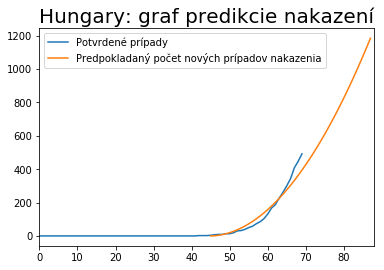

In [46]:
# Pre predikciu novych pripadov vyuzijem Linearnu regresiu
# Pridala som import sklearn
for country in df_train['Country_Region'].unique():
    # print('Robim model pre krajinu: {}'.format(country))
    df_train_country = df_train[df_train['Country_Region'] == country]
    df_test_country = df_test[df_test['Country_Region'] == country]
    
    # zaujima ma, ci ma krajina provinciu, ak ano -> vetva else
    if df_train_country['Province_State'].isnull().unique().any():
        # indexujem krajiny v csv subore - od a do
        x_train = np.array(range(len(df_train_country))).reshape((-1, 1))
        #print(x_train)
        y_train = df_train_country['ConfirmedCases']
        # print(y_train)
        
        # ucenie siete
        model = Pipeline([('poly', PolynomialFeatures(degree=2, include_bias=True)), ('linear', LinearRegression(fit_intercept=False))])
        
        Y = np.array([y_train])
        Yr = np.flip(Y, axis=1)
        Yr = Yr[0,::-1]
        Yrs = Yr.reshape(-1,1)
        x_train_scale = StandardScaler().fit_transform(x_train)
        y_train_scale = StandardScaler().fit_transform(Yrs)
        
        model.fit(x_train_scale, y_train_scale)
        
        # zacnem indexovat dni od 0
      
        x_test = np.array(range(len(df_test_country))).reshape((-1, 1))
        prediction = model.predict(x_test)
        
        # negativne pripady nahradim nulou
        prediction[prediction < 0] = 0
        
        # Vramci ConfirmedCases pridam sa novy stlpec v dataframe df_test kam vlozim predikciu k danej krajine
        df_test.loc[df_test['Country_Region'] == country, 'ConfirmedCases'] = prediction
       
        # print(df_test['ConfirmedCases'].astype('int'))
        
        if(country == "Hungary"):
             # Visualising the Polynomial Regression results
             
            #print(x_train)
            # Y = np.array([y_train])
            # Yr = np.flip(Y, axis=1)
         
            plt.plot(x_train[:70,0], Yrs[:70,0])
            plt.xlim(0,10)
        
            #print(prediction)
            plt.plot(x_test+45, prediction)
            plt.xlim(0,88)
            plt.legend(['Potvrdené prípady', 'Predpokladaný počet nových prípadov nakazenia'])
            plt.title(country+': graf predikcie nakazení', size=20)
            
            plt.show()
        
    else:
        for state in df_train_country['Province_State'].unique():
            df_train_state = df_train_country[df_train_country['Province_State'] == state]
            df_test_state = df_test_country[df_test_country['Province_State'] == state]
            
            x_train = np.array(range(len(df_train_state))).reshape(-1, 1)
            y_train = df_train_state['ConfirmedCases']
            
            
            model = Pipeline([('poly', PolynomialFeatures(degree=2, include_bias=True)), ('linear', LinearRegression(fit_intercept=False))])
        
            Y = np.array([y_train])
            Yr = np.flip(Y, axis=1)
            Yr = Yr[0,::-1]
            Yrs = Yr.reshape(-1,1)
            x_train_scale = StandardScaler().fit_transform(x_train)
            y_train_scale = StandardScaler().fit_transform(Yrs)
        
            model.fit(x_train_scale, y_train_scale)
            
            x_test = np.array(range(len(df_test_state))).reshape((-1, 1))
            prediction = model.predict(x_test)
            
            prediction[prediction < 0] = 0
            
            # Vramci ConfirmedCases pridam sa novy stlpec v dataframe df_test kam vlozim predikciu k danej krajine
            df_test.loc[(df_test['Country_Region'] == country) & (df_test['Province_State'] == state), 'ConfirmedCases'] = prediction

## Vloženie naučených dát do *submission.csv*

In [19]:
# len vlozim data do pripraveneho csv suboru
df_submit = pd.read_csv('submission.csv')
df_submit['ConfirmedCases'] = df_test['ConfirmedCases'].astype('int')
df_submit.to_csv('submission.csv', index=False)

In [20]:
# df_test.head()

In [21]:
# df_train.info()

## Tabuľka predikcie nových nakazení od 1.5.2020
Slúži na porovnanie s aktuálnymi údajmi

In [48]:
slovakia = df_test[df_test['Country_Region'] == 'Slovakia']
slovakia = slovakia.astype({"ConfirmedCases": int})

slovakia['Date'] = pd.to_datetime(slovakia.Date)
slovakia['Date'] = slovakia['Date'].dt.strftime('%d.%m.%Y')

print(slovakia[29:])

      ForecastId Province_State Country_Region        Date  ConfirmedCases
9360        9361            NaN       Slovakia  01.05.2020             541
9361        9362            NaN       Slovakia  02.05.2020             578
9362        9363            NaN       Slovakia  03.05.2020             617
9363        9364            NaN       Slovakia  04.05.2020             656
9364        9365            NaN       Slovakia  05.05.2020             697
9365        9366            NaN       Slovakia  06.05.2020             739
9366        9367            NaN       Slovakia  07.05.2020             783
9367        9368            NaN       Slovakia  08.05.2020             827
9368        9369            NaN       Slovakia  09.05.2020             873
9369        9370            NaN       Slovakia  10.05.2020             920
9370        9371            NaN       Slovakia  11.05.2020             969
9371        9372            NaN       Slovakia  12.05.2020            1018
9372        9373         